<a href="https://colab.research.google.com/github/azhgh22/Walmart-Recruiting-Store-Sales-Forecasting/blob/main/notebooks/statistical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip walmart-recruiting-store-sales-forecasting.zip
! rm walmart-recruiting-store-sales-forecasting.zip
! unzip features.csv.zip
! rm features.csv.zip
! unzip train.csv.zip
! rm train.csv.zip
! unzip test.csv.zip
! rm test.csv.zip
! unzip sampleSubmission.csv.zip
! rm sampleSubmission.csv.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 36.7 MB/s eta 0:00:00
Mounted at /content/drive
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 788MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


## **Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

In [59]:
TRAIN_SIZE = 0.7

In [5]:
train['Date'] = pd.to_datetime(train['Date'])
train = train.sort_values(by='Date')

In [78]:
class TimeSeriesSplit:
    def __init__(self, train_size:int) -> None:
        self.train_size = train_size
        self.val_size = 1 - train_size

    def split(self, data:pd.DataFrame) -> tuple[pd.DataFrame,pd.DataFrame]:
        data = data.copy().sort_values(by='Date')
        start_week = data['Date'].min()
        end_week = data['Date'].max()
        data['Date'] = ((data['Date'] - start_week).dt.days // 7).astype(int)
        train_data = data.iloc[:int(self.train_size*data.shape[0])]
        val_data = data.iloc[int(self.train_size*data.shape[0]):]
        return train_data, val_data

In [70]:
class Filter:
  def get_query(self) -> str:
    pass

In [77]:
class DataFilter:
    def filter(self, data:pd.DataFrame, filter:Filter) -> pd.DataFrame:
        return data.query(filter.get_query())

In [75]:
class ComposeFilter(Filter):
    def __init__(self, filter_list:list[Filter]) -> None:
        self.filter_list = filter_list

    def get_query(self) -> str:
        return ' and '.join([filter.get_query() for filter in self.filter_list])

In [82]:
class StoreFilter(Filter):
    def __init__(self, store_id:int) -> None:
        self.store_id = store_id

    def get_query(self) -> str:
        return f'Store=={self.store_id}'

In [83]:
class DeptFilter(Filter):
    def __init__(self, dept_id:int) -> None:
        self.dept_id = dept_id

    def get_query(self) -> str:
        return f'Dept=={self.dept_id}'

In [84]:
DataFilter().filter(train, ComposeFilter([StoreFilter(1),DeptFilter(1)]))

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
138,1,1,2012-09-28,18947.81,False
139,1,1,2012-10-05,21904.47,False
140,1,1,2012-10-12,22764.01,False
141,1,1,2012-10-19,24185.27,False


In [61]:
train_part, val_part = TimeSeriesSplit(TRAIN_SIZE).split(DataFilter().filter(train, [StoreFilter(1),DeptFilter(1)]))

In [85]:
class DeptKeeper:
    def __init__(self, data:pd.DataFrame,train_size:int,dept_id:int) -> None:
        self.train_mapping:dict[int,pd.DataFrame] = {}
        self.val_mapping:dict[int,pd.DataFrame] = {}
        for store in data['Store'].unique():
            compose_filter = ComposeFilter([StoreFilter(store),DeptFilter(dept_id)])
            filtered = DataFilter().filter(data, compose_filter)
            train_part, val_part = TimeSeriesSplit(train_size).split(filtered)
            self.train_mapping[store] = train_part
            self.val_mapping[store] = val_part

    def get_train(self,store_id:int) -> pd.DataFrame:
        return self.train_mapping[store_id]

    def get_val(self,store_id:int) -> pd.DataFrame:
        return self.val_mapping[store_id]

In [88]:
dept1 = DeptKeeper(train,TRAIN_SIZE,1)

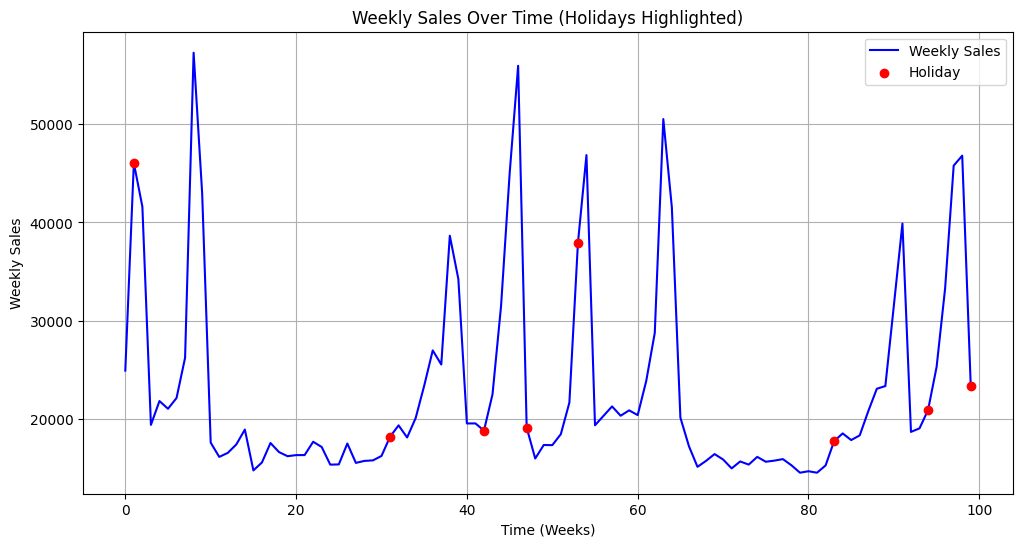

In [89]:
holidays = dept1.get_train(1)[train_part['IsHoliday'] == True]

plt.figure(figsize=(12, 6))
plt.plot(dept1.get_train(1)['Date'], dept1.get_train(1)['Weekly_Sales'], label='Weekly Sales', color='blue')
plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()